## CPOL and Berrima Dual Doppler test

Based on code created by Scott Collis, Johnathan Helmus, Zachary Sherman, and myself.<br />
Uses the OU DDA code to generate Dual Doppler Analysis.<br />

This version uses the pregridded files that were provided by Scott

In [558]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
import time
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline
import multidop
from mpl_toolkits import basemap
from netCDF4 import Dataset

In [559]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 19
start_month = 1
start_hour = 23
start_minute = 50
start_second = 0

end_year = 2006
end_month = 1
end_day = 20
end_hour = 1
end_minute = 0
end_second = 0

data_path_pregrid = '/home/rjackson/data/radar/gridded_data/'

sounding_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20020401.043300..20091230.172000.custom.cdf'

This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [560]:
# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_gridded(start_year, start_month, start_day,
                            start_hour, start_minute, end_year,
                            end_month, end_day, end_hour, 
                            end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
# 20060119_0000_v1.0_osra_pp_winds_winds_pp.nc
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_pregrid +
                      year_str +
                      month_str +
                      day_str +
                      '*v1.0_osra_pp_winds_winds_pp.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_pregrid +
                              year_str +
                              month_str +
                              day_str +
                              '*v1.0_osra_pp_winds_winds_pp.nc')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-44:-31]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),)
                            
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
        
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):           
            
            time_list_final.append(cur_time)
            past_time = cur_time                
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_grid(time, x_min, x_max, y_min, y_max, z_min, z_max):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_pregrid +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     '_v1.0_osra_pp_winds_winds_pp.nc')
    print('Loading ' + file_name_str)
    
    # The pregridded files are not loadable using read_grid, 
    # so load in the necessary fields and make the Grid object out of them
    grid_cdf = Dataset(file_name_str)
    FillValue = -32768
    
    # Add grid locations
    grid_x = {'data': np.squeeze(grid_cdf.variables['xar'][:])}
    grid_y = {'data': np.squeeze(grid_cdf.variables['yar'][:])}
    levs = {'data': np.squeeze(grid_cdf.variables['levs'][:])}
    
    # Get indicies for sub-domain
    inds_x = np.squeeze(np.where(np.logical_and(grid_x['data'] >= x_min, grid_x['data'] <= x_max)))
    inds_y = np.squeeze(np.where(np.logical_and(grid_y['data'] >= y_min, grid_y['data'] <= y_max)))
    inds_z = np.squeeze(np.where(np.logical_and(levs['data'] >= z_min, levs['data'] <= z_max)))
    
    # Apply masks
    # DDA does not converge when bottom of domain is z=0,
    # so only use 0.5 km and higher for vertical levels
    cpol_mask = grid_cdf.variables['mask_radar1'][inds_x,inds_y,inds_z]
    cpol_vel = grid_cdf.variables['VE_radar1'][inds_x,inds_y,inds_z]
    cpol_ref = grid_cdf.variables['CZ_radar1'][inds_x,inds_y,inds_z] 
    cpol_vel = np.ma.masked_array(cpol_vel, 1-cpol_mask)
    cpol_ref = np.ma.masked_array(cpol_ref, 1-cpol_mask)
    masked_values = np.where(np.ma.getmaskarray(cpol_vel) == True)
    normal_values = np.where(np.ma.getmaskarray(cpol_vel) == False)
    cpol_vel[masked_values] = FillValue
    cpol_ref[masked_values] = FillValue
    
    
    # Place into dictionary
    VE_cpol = {'data': np.transpose(cpol_vel),
               'long_name': 'corrected_velocity',
               'units': 'm/s',
               '_FillValue': FillValue}
    
    CZ_cpol = {'data': np.transpose(cpol_ref),
               'long_name': 'corrected_reflectivity',
               'units': 'dBZ',
               '_FillValue': FillValue}
    cpol_location = grid_cdf.variables['radar1_loc'][:]
    
    # Apply mask to reflectivity and velocity
    berr_mask = grid_cdf.variables['mask_radar1'][inds_x,inds_y,inds_z]
    berr_vel = grid_cdf.variables['VE_radar2'][inds_x,inds_y,inds_z]
    berr_ref = grid_cdf.variables['CZ_radar2'][inds_x,inds_y,inds_z]
    berr_vel = np.ma.masked_array(berr_vel, 1-berr_mask)
    berr_ref = np.ma.masked_array(berr_ref, 1-berr_mask)
    masked_values = np.where(np.ma.getmaskarray(berr_vel) == True)
    normal_values = np.where(np.ma.getmaskarray(berr_vel) == False)
    berr_vel[masked_values] = FillValue
    berr_ref[masked_values] = FillValue
    
    # Place velocity and reflectivity into dictionary
    VE_berr = {'data': np.transpose(berr_vel),
               'long_name': 'corrected_velocity',
               'units': 'm/s',
               '_FillValue': FillValue}
    CZ_berr = {'data': np.transpose(berr_ref),
               'long_name': 'corrected_reflectivity',
               'units': 'dBZ',
               '_FillValue': FillValue}
    berr_location = grid_cdf.variables['radar2_loc'][:]
    
    dual_dop_u = grid_cdf.variables['u_array_radar1'][inds_x,inds_y,inds_z]
    dual_dop_u = np.ma.masked_array(dual_dop_u, 1-cpol_mask, fill_value=-9999.0)
    dual_dop_v = grid_cdf.variables['v_array_radar1'][inds_x,inds_y,inds_z]
    dual_dop_v = np.ma.masked_array(dual_dop_v, 1-cpol_mask, fill_value=-9999.0)
    dual_dop_w = grid_cdf.variables['w_array_radar1'][inds_x,inds_y,inds_z]
    dual_dop_w = np.ma.masked_array(dual_dop_u, 1-cpol_mask, fill_value=-9999.0)
    
    # Original Dual Doppler retrievals look like they are in CPOL's coordinates
    # So, add them to CPOL's grid
    #u_cpol = {'data': np.transpose(dual_dop_u),
    #          'long_name': 'U_component_wind'}    
    #v_cpol = {'data': np.transpose(dual_dop_v),
    #          'long_name': 'V_component_wind'}
    #w_cpol = {'data': np.transpose(dual_dop_w),
    #          'long_name': 'W_component_wind'}
    
    
    # Restrict data to sub-domain
    grid_x = {'data': np.squeeze(grid_cdf.variables['xar'][:,inds_x])}
    grid_y = {'data': np.squeeze(grid_cdf.variables['yar'][:,inds_y])}
    levs = {'data': np.squeeze(grid_cdf.variables['levs'][:,inds_z])}

    
    # Add grid fields
    cpol_grid_fields = {'VT': VE_cpol,
                        'DT': CZ_cpol}
    
    metadata = {}
    
    berr_grid_fields = {'VT': VE_berr,
                        'DT': CZ_berr}
    
    # Add latitude and longitude entries for each radar
    origin_latitude = {'data': [cpol_location[0,0]],
                       'units': 'degrees'}
    origin_longitude = {'data': [cpol_location[0,1]],
                        'units': 'degrees'}
    cpol_latitude = {'data': [cpol_location[0,0]],
                       'units': 'degrees'}
    cpol_longitude = {'data': [cpol_location[0,1]],
                        'units': 'degrees'}
    berr_latitude = {'data': [berr_location[0,0]],
                       'units': 'degrees'}
    berr_longitude = {'data': [berr_location[0,1]],
                        'units': 'degrees'}
    origin_altitude = {'data': [50.],
                       'units': 'meters'}
    cpol_altitude = {'data': [50.],
                       'units': 'meters'}
    berr_altitude = {'data': [0.],
                       'units': 'meters'}
    cpol_name = {'data': 'C'}
    berr_name = {'data': 'B'}
    
    time_dict = {'units': ('seconds since ' + 
                           year_str + 
                           '-' + 
                           month_str + 
                           '-' + 
                           day_str + 
                           'T' + 
                           hour_str + 
                           ':' + 
                           minute_str + 
                           ':' +
                           second_str + 'Z'), 
                 'long_name': 'Time of grid', 'standard_name': 
                 'time', 'data': np.array([0.], dtype=float), 
                 'calendar': 'gregorian'}
    
    # Create grid objects
    grid_cpol = pyart.core.Grid(time_dict, 
                                cpol_grid_fields,
                                metadata,
                                origin_latitude,
                                origin_longitude,
                                origin_altitude,
                                grid_x, 
                                grid_y,
                                levs, 
                                radar_latitude=cpol_latitude,
                                radar_longitude=cpol_longitude,
                                radar_altitude=cpol_altitude,
                                radar_name=cpol_name,
                                radar_time=time_dict)
    grid_berr = pyart.core.Grid(time_dict, 
                                berr_grid_fields,
                                metadata,
                                origin_latitude,
                                origin_longitude,
                                origin_altitude,
                                grid_x, 
                                grid_y,
                                levs, 
                                radar_latitude=berr_latitude,
                                radar_longitude=berr_longitude,
                                radar_altitude=berr_altitude,
                                radar_name=berr_name,
                                radar_time=time_dict)
    print(grid_x)
    print(grid_y)
    print(levs)
    return grid_cpol, grid_berr



In [561]:
# Plot the radars from given time.

times = get_radar_times_gridded(start_year, start_month, start_day,
                                start_hour, start_minute, end_year,
                                end_month, end_day, end_hour, 
                                end_minute, minute_interval=10)

print(times[2])

We are about to load grid files for 2 days
Looking for files with format /home/rjackson/data/radar/gridded_data/20060119*v1.0_osra_pp_winds_winds_pp.nc
Looking for files with format /home/rjackson/data/radar/gridded_data/20060120*v1.0_osra_pp_winds_winds_pp.nc
2006-01-20 00:50:00


This calculates the texture of the velocity field for both radars.

In [562]:
# Load the gridded data
frame_number = 2
x_min = -50000.0
x_max = 50000.0
y_min = -50000.0
y_max = 50000.0
z_min = 1000.0
z_max = 19000.0
grid_cpol, grid_berr = get_radar_from_grid(times[2], x_min, 
                                           x_max, y_min, 
                                           y_max, z_min, 
                                           z_max)
print(grid_cpol.nz)

Loading /home/rjackson/data/radar/gridded_data/20060120_0050_v1.0_osra_pp_winds_winds_pp.nc
{'data': array([-75000., -74000., -73000., -72000., -71000., -70000., -69000.,
       -68000., -67000., -66000., -65000., -64000., -63000., -62000.,
       -61000., -60000., -59000., -58000., -57000., -56000., -55000.,
       -54000., -53000., -52000., -51000., -50000., -49000., -48000.,
       -47000., -46000., -45000., -44000., -43000., -42000., -41000.,
       -40000., -39000., -38000., -37000., -36000., -35000., -34000.,
       -33000., -32000., -31000., -30000., -29000., -28000., -27000.,
       -26000., -25000., -24000., -23000., -22000., -21000., -20000.,
       -19000., -18000., -17000., -16000., -15000., -14000., -13000.,
       -12000., -11000., -10000.,  -9000.,  -8000.,  -7000.,  -6000.,
        -5000.,  -4000.,  -3000.,  -2000.,  -1000.,      0.,   1000.,
         2000.,   3000.,   4000.,   5000.,   6000.,   7000.,   8000.,
         9000.,  10000.,  11000.,  12000.,  13000.,  14000.

This plots the reflectivity.

In [563]:
# The analysis engine currently expects the "missing_value" attribute
grid_cpol.fields['DT']['missing_value'] = 1.0 * grid_cpol.fields['DT']['_FillValue']
grid_berr.fields['DT']['missing_value'] = 1.0 * grid_berr.fields['DT']['_FillValue']
grid_cpol.fields['VT']['missing_value'] = 1.0 * grid_cpol.fields['VT']['_FillValue']
grid_berr.fields['VT']['missing_value'] = 1.0 * grid_berr.fields['VT']['_FillValue']

# The analysis engine requires azimuth and elevation to be part of the grid.
# This information is computed from the grid geometry.
grid_cpol = multidop.angles.add_azimuth_as_field(grid_cpol)
grid_berr = multidop.angles.add_azimuth_as_field(grid_berr)
grid_cpol = multidop.angles.add_elevation_as_field(grid_cpol)
grid_berr = multidop.angles.add_elevation_as_field(grid_berr)

# Grid 1 set elevations to bad data
bad = -32768
vt = 1.0 * grid_cpol.fields['VT']['data'].filled(bad)
dz = 1.0 * grid_cpol.fields['DT']['data'].filled(bad)
try:
    el = 1.0 * grid_cpol.fields['EL']['data'].filled(bad)
except AttributeError:
    el = 1.0 * grid_cpol.fields['EL']['data']
try:
    az = 1.0 * grid_cpol.fields['AZ']['data'].filled(bad)
except AttributeError:
    az = 1.0 * grid_cpol.fields['AZ']['data']
vt = np.ma.masked_where(vt < -99, vt)
dz = np.ma.masked_where(dz < -99, dz)
cond = np.isfinite(el)
el[~cond] = bad
el = np.ma.masked_where(el < -99, el)
az = np.ma.masked_where(az < -99, az)
grid_cpol.fields['VT']['data'] = vt
setattr(grid_cpol.fields['VT']['data'], 'mask', vt.mask)
grid_cpol.fields['DT']['data'] = dz
setattr(grid_cpol.fields['DT']['data'], 'mask', dz.mask)
grid_cpol.fields['EL']['data'] = el
setattr(grid_cpol.fields['EL']['data'], 'mask', el.mask)
grid_cpol.fields['AZ']['data'] = az
setattr(grid_cpol.fields['AZ']['data'], 'mask', az.mask)
for fld in ['VT', 'DT', 'EL', 'AZ']:
    grid_cpol.fields[fld]['_FillValue'] = bad
    grid_cpol.fields[fld]['missing_value'] = bad

# Grid 2 set elevations to bad data
bad = -32768
vt = 1.0 * grid_berr.fields['VT']['data'].filled(bad)
dz = 1.0 * grid_berr.fields['DT']['data'].filled(bad)
try:
    el = 1.0 * grid_berr.fields['EL']['data'].filled(bad)
except AttributeError:
    el = 1.0 * grid_berr.fields['EL']['data']
try:
    az = 1.0 * grid_berr.fields['AZ']['data'].filled(bad)
except AttributeError:
    az = 1.0 * grid_berr.fields['AZ']['data']
vt = np.ma.masked_where(vt < -99, vt)
dz = np.ma.masked_where(dz < -99, dz)
cond = np.isfinite(el)
el[~cond] = bad
el = np.ma.masked_where(el < -99, el)
az = np.ma.masked_where(az < -99, az)
grid_berr.fields['VT']['data'] = vt
setattr(grid_berr.fields['VT']['data'], 'mask', vt.mask)
grid_berr.fields['DT']['data'] = dz
setattr(grid_berr.fields['DT']['data'], 'mask', dz.mask)
grid_berr.fields['EL']['data'] = el
setattr(grid_berr.fields['EL']['data'], 'mask', el.mask)
grid_berr.fields['AZ']['data'] = az
setattr(grid_berr.fields['AZ']['data'], 'mask', az.mask)
for fld in ['VT', 'DT', 'EL', 'AZ']:
    grid_berr.fields[fld]['_FillValue'] = bad
    grid_berr.fields[fld]['missing_value'] = bad    
    
# Save the input grids for later.
pyart.io.write_grid('cpol_Darwin_pregrid.nc', grid_cpol)
pyart.io.write_grid('berr_Darwin_pregrid.nc', grid_berr)

In [564]:
grid_cpol = pyart.io.read_grid('cpol_Darwin_pregrid.nc')
grid_berr = pyart.io.read_grid('berr_Darwin_pregrid.nc')

### Test grid output

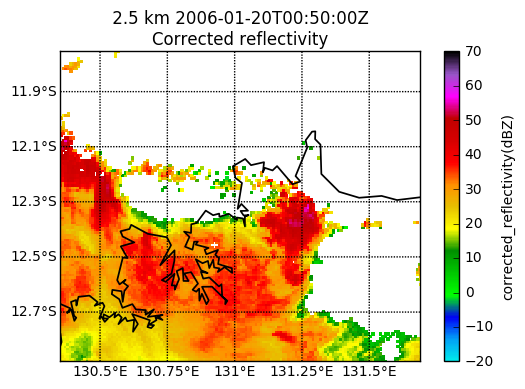

In [565]:
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_basemap(min_lat=-12.75, max_lat=-12,
                             min_lon=130.5, max_lon=131.5,
                             lat_lines=[-12.7, -12.5, -12.3, -12.1, -11.9],
                             lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                             resolution='i')
CPOLGridDisplay.plot_grid('DT', 3, vmin=-20, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

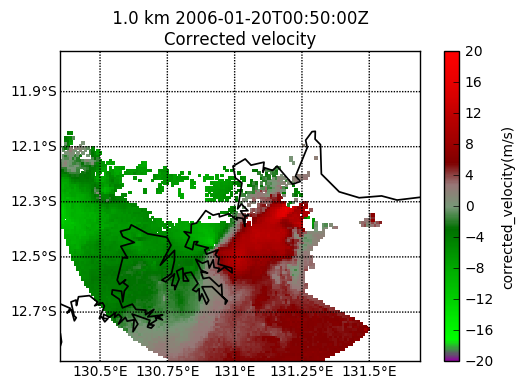

In [566]:
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_berr)
CPOLGridDisplay.plot_basemap(min_lat=-12.75, max_lat=-12,
                             min_lon=130.5, max_lon=131.5,
                             lat_lines=[-12.7, -12.5, -12.3, -12.1, -11.9],
                             lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                             resolution='i')
CPOLGridDisplay.plot_grid('VT', 0, vmin=-20, vmax=20,
                          cmap=pyart.graph.cm.NWSVel)

CPOL Vertical cross sections....right now these grids have more discontinuties and
data gaps compared to paper.

(-10, 30)

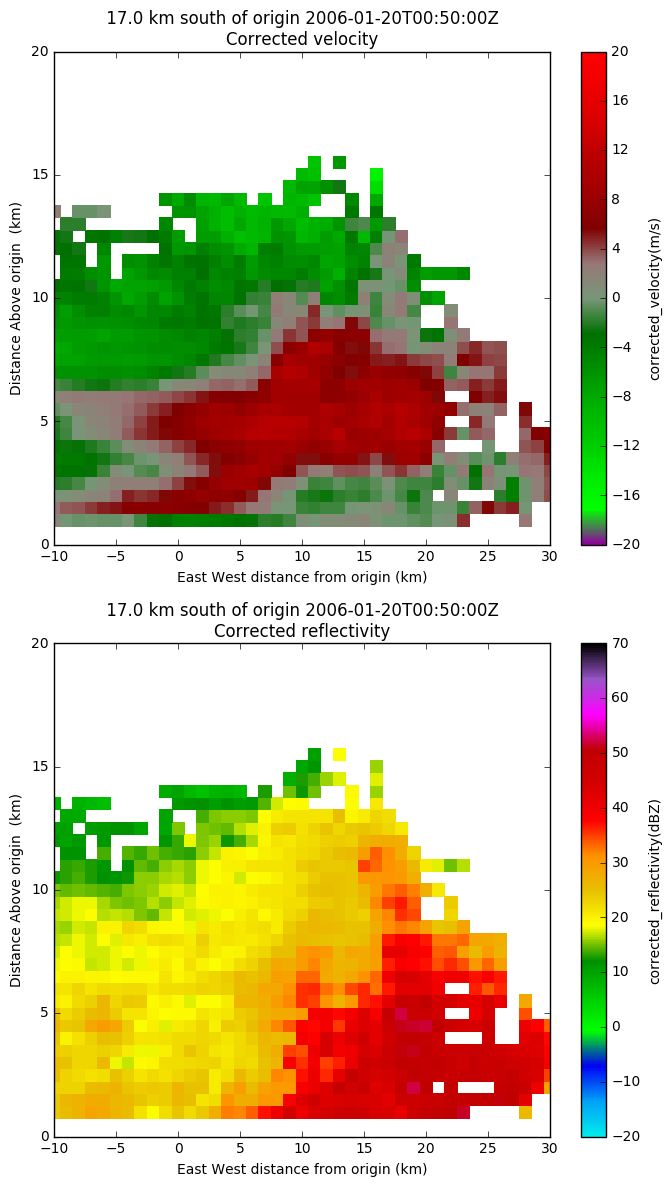

In [567]:
plt.figure(figsize=(8,14))
plt.subplot(211)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_latitude_slice('VT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSVel,
                                    vmin=-20, vmax=20)                           
                                    
plt.xlim([-10, 30])

plt.subplot(212)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_latitude_slice('DT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSRef,
                                    vmin=-20, vmax=70)                           
                                    
plt.xlim([-10, 30])

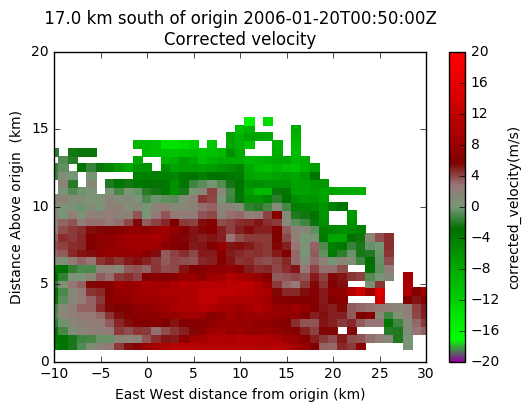

In [568]:
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_berr)
CPOLGridDisplay.plot_latitude_slice('VT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSVel,
                                    vmin=-20, vmax=20)                           
                                    
plt.xlim([-10, 30])

vt = grid_berr.fields['DT']['data'][:,:,:]
dims = np.shape(vt)

In [569]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-50000.0, 1000.0, 101],   # start, step, max = min + (steps-1)
      'y': [-50000.0, 1000.0, 101],
      'z': [1000.0, 500.0, 37],
      'grid': [grid_cpol.origin_longitude['data'][0], grid_cpol.origin_latitude['data'][0], 50.0],
      'files': ['berr_Darwin_pregrid.nc',
                'cpol_Darwin_pregrid.nc'],
      'radar_names': ['Berrima', 'CPOL'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': None, # Name of sounding file
      'writeout': localfile.name, # Name of output grid file
      'min_cba': 30.0,  # Minimum beam-crossing angle
      'calc_params': 'cpol_calc.dda', # .dda file for parameters related to minimization routine
      'anel': 1, # 0 = Boussinesq approximation for mass conservation, 1 = anelastic 
      'laplace': 0, # 0 = 1st order derivatives for smoothing, 1 = second
      'read_dataweights': 2, # 0 = calculate data constraint weights/output, 1 = read from file, 2 = weigh all equally
      'max_dist': 10.0,
      'cutoff': 0.0, # Deny observations below this level from analysis (m)
      'UT': 0.0, # U of prescribed storm motion vector
      'VT': 0.0, # V of prescribed storm motion vector
      'output_error': 1, # 1 = output verification stats after each iteration
      'weak_height': -1, # Sounding height constraint weakened in regions > 10 dBZ below this height (-1 = disabled)
      'upper_bc': 1, # 1 = w = 0 as upper boundary condition, -1 = ignore
      'itmax_frprmn': [200, 10], # max iterations in frprmn function
      'itmax_dbrent': 200, # max iterations in dbrent function
      'C1b': 1.0,  # Data weighting factor
      'C2b': 10.0,  # Mass continuity weighting factor
      'C3b': 0.0,  # Vorticity weighting factor
      'C4b': 1.0,  # Horizontal smoothing factor
      'C5b': 1.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0, # 0 = constant weights, 1 = vary weights
      # Define filter with ONE of the following forms.
      # filter: none
      # filter: filter_frequency Leise nstep
      # filter: filter_frequency low-pass alpha
      'filter': ['none', '', ''], 
      # Coverage values for various combinations of radars.
      # Each line should provide the type of coverage value, radar count,
      # radar names, and the value, in the following form:
      #
      #   cvg_(""|opt|sub)_(bg|fil): integer radar1 radar2 ... boolean
      #
      # Radars are identified by the OPAWS/OBAN file name with grid data for that
      # radar. This must be just the base name, not the full path.
      #
      # For example:
      #
      #   cvg_opt_bg: SR1 SR2 1
      #
      # says that if SR1 SR2
      # both have data within max_dist meters of the point under consideration,
      # and an optimal beam crossing angle, then the point will receive a coverage
      # value of 1, i.e. point has coverage.
      #
      # "opt" means optimal beam crossing angle.
      # "sub" means suboptimal beam crossing angle.
      # "bg" means background coverage.
      # "fil" means filter coverage.
      # cvg_bg, cvg_fil, and sseq_trip do not require a radar count. (Beam crossing
      # angle is meaningless with one radar, so there is no opt or sub)
      #
      # If this file is being used, coverage values must be provided for all
      # combinations of radars.
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [0, 1, 1],
      'cvg_opt_fil': [0, 1, 1],
      'cvg_sub_fil': [0, 0, 0],
      'cvg_bg': [0, 0, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'cpol_test_pregrid.dda')
pf = multidop.parameters.CalcParamFile(pd, 'cpol_calc_pregrid.dda')

In [570]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('cpol_test_pregrid.dda', cmd_path='/home/rjackson/multidop/src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.8.2
./DDA: reading calculation parameters from cpol_calc.dda.
Changing working directory to ./
x: -75000.000000 to 70000.000000 in 145 steps of 1000.000000
y: -70000.000000 to 55000.000000 in 125 steps of 1000.000000
z: 1000.000000 to 19000.000000 in 36 steps of 500.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 30 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART fileberr_Darwin_pregrid.nc
cpol_Darwin_pregrid.nc

Radar positions:  (-12912.7,-23087.4) (47.7183,3.69992)
Computing coverage: 130195 verification points out of 680652 total points.
radar0 130195 obs. radar1 130195 obs. 260390 total obs.
Analyzed obs = 260390. Mean Vr = 6.39664
C1b=1 C2b=10 C3b=0 C4b=1 C5b=1 C6b=1 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=1 C6a=1 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 93738.9
GradCheck: gxnn = 13327.2
GradCheck: j = 1. f

In [571]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid_pregrid.nc'
final_grid = multidop.grid_io.make_new_grid([grid_berr, grid_cpol], localfile.name)
final_grid.write(fname)
localfile.close()

(array([0]),)


In [572]:
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

[u'eastward_wind', u'reflectivity', u'upward_air_velocity', u'northward_wind']


## Display merged reflectivities



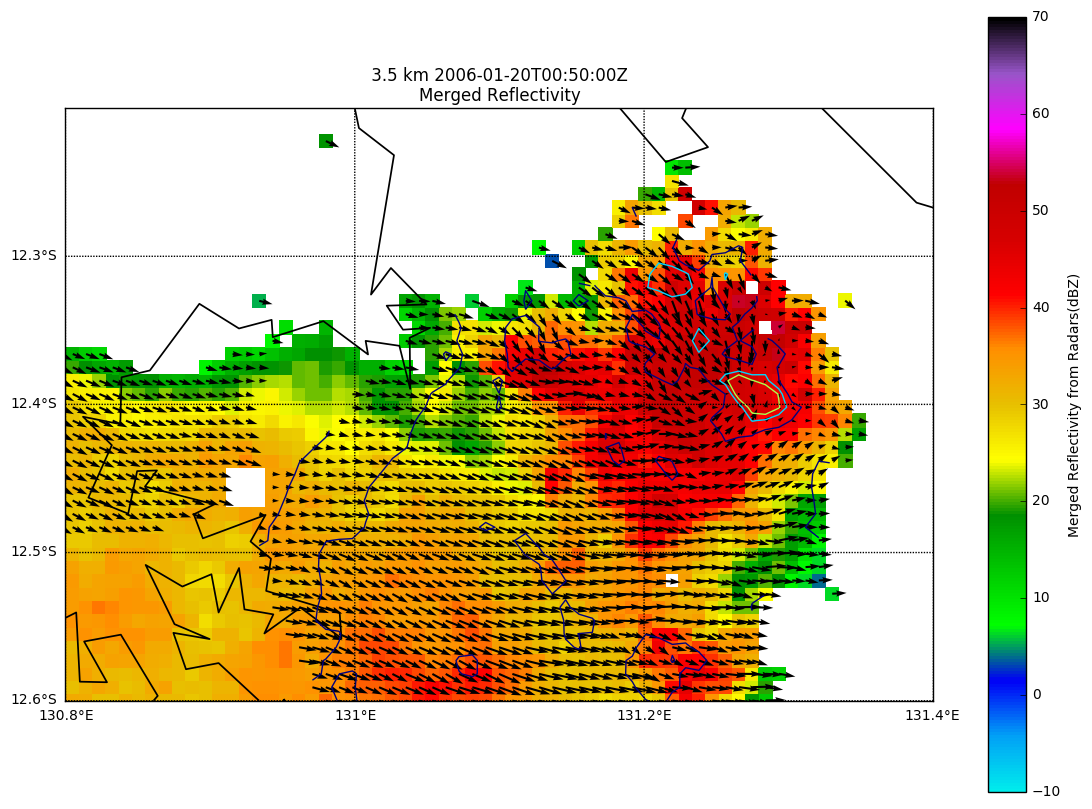

In [573]:
level = 5
fig1 = plt.figure(figsize=(14,10))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_basemap(min_lat=-12.6, max_lat=-12.2,
                             min_lon=130.8, max_lon=131.4,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2],
                             lon_lines=[130.8, 131.0, 131.2, 131.4],
                             resolution='i')
CPOLGridDisplay.plot_grid('reflectivity', level, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid.fields['northward_wind']['data'][level]
u = pyart_grid.fields['eastward_wind']['data'][level]
w = pyart_grid.fields['upward_air_velocity']['data'][level]
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)

CPOLGridDisplay.basemap.quiver(lons, lats, 
                               u, v, 
                               scale=600,
                               latlon='True')
CPOLGridDisplay.basemap.contour(lons, lats,
                                w, latlon='True',
                                levels=[1, 4, 6, 10])

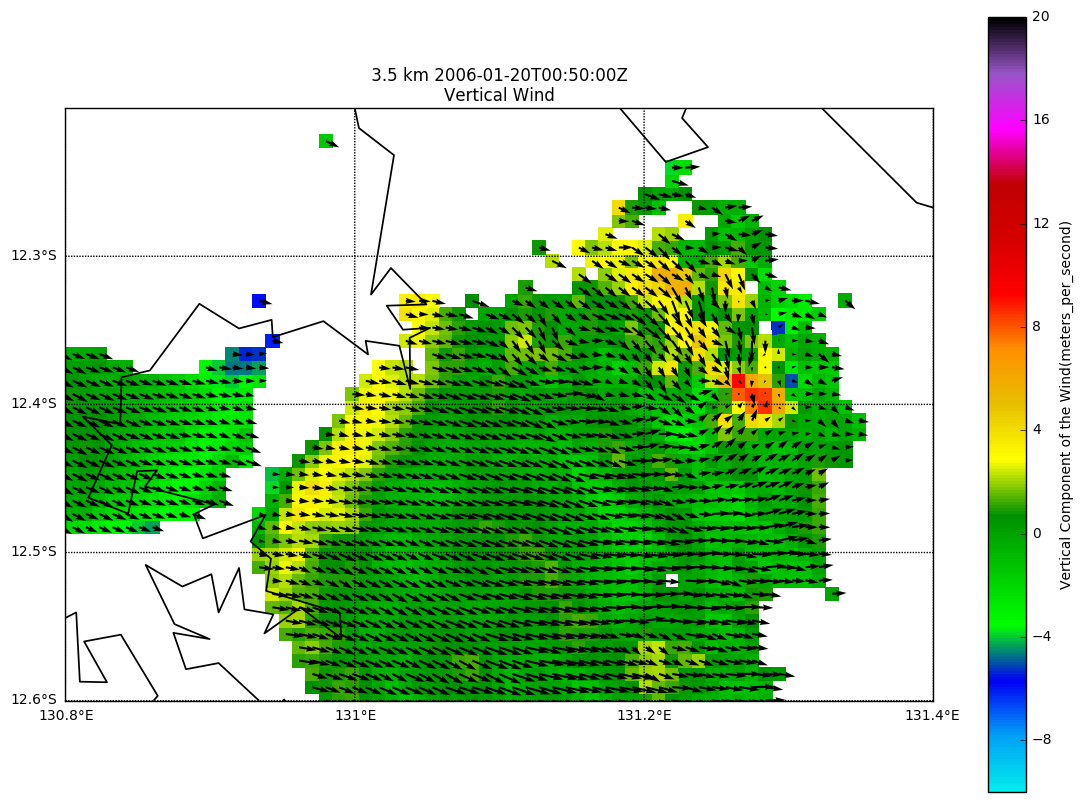

In [574]:
level = 5
fig1 = plt.figure(figsize=(14,10))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_basemap(min_lat=-12.6, max_lat=-12.2,
                             min_lon=130.8, max_lon=131.4,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2],
                             lon_lines=[130.8, 131.0, 131.2, 131.4],
                             resolution='i')
CPOLGridDisplay.plot_grid('upward_air_velocity', level, vmin=-10, vmax=20,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid.fields['northward_wind']['data'][level]
u = pyart_grid.fields['eastward_wind']['data'][level]
CPOLGridDisplay.basemap.quiver(lons, lats, 
                               u, v, 
                               scale=600,
                               latlon='True')

(-20, 40)

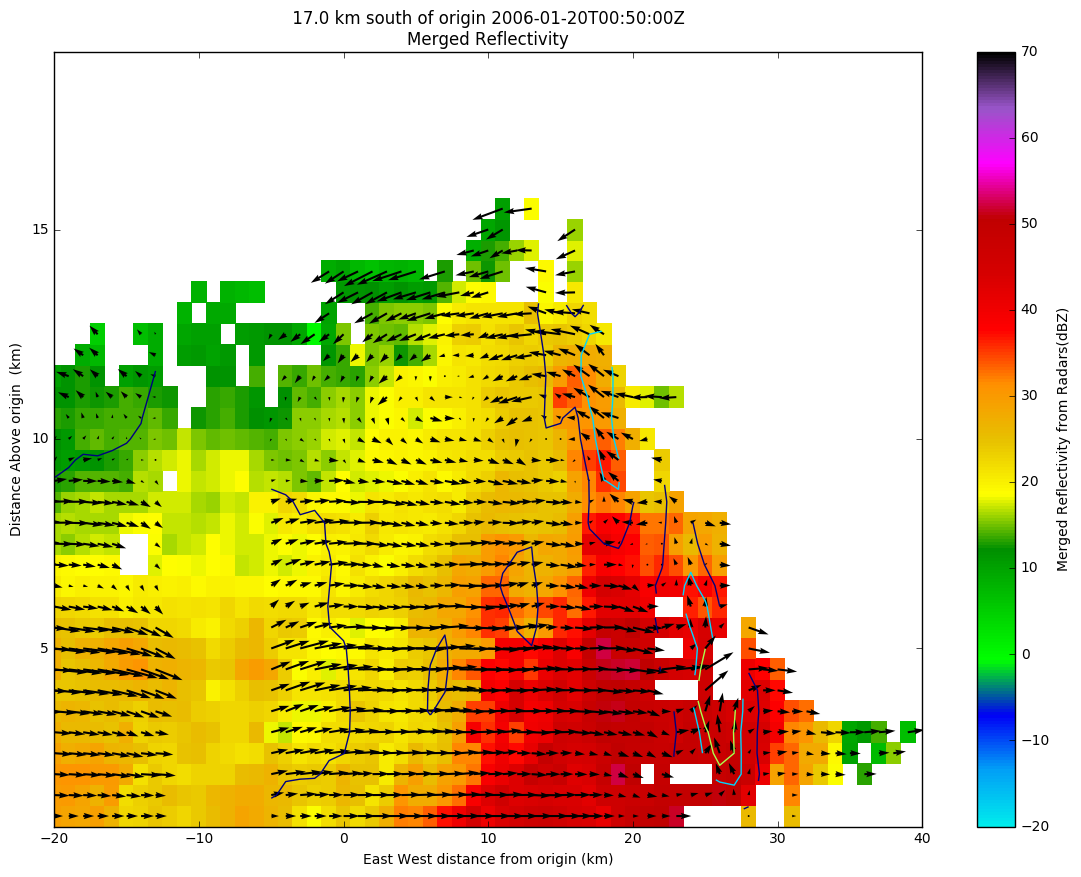

In [580]:
fig1 = plt.figure(figsize=(14,10))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_latitudinal_level('reflectivity', 53,
                                       cmap=pyart.graph.cm.NWSRef,
                                       vmin=-20, vmax=70)                           

X,Y = np.meshgrid(pyart_grid.x['data']/1e3, pyart_grid.z['data']/1e3)
v = pyart_grid.fields['upward_air_velocity']['data'][:,53,:]
u = pyart_grid.fields['eastward_wind']['data'][:,53,:]
plt.quiver(X, Y, u, v, scale=400)
plt.contour(X,Y,v,levels=[1,4,6,10])
plt.xlim([-20, 40])